<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/karlguen/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6: Deep Learning with CNNs for Star Morphology Analysis


# Installing required libraries

In [205]:
# Install required libraries
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch astroquery ipytest

In [206]:
import ipytest
ipytest.autoconfig()
import pytest

# Pytest Notes
 For pytest to recognize a test function it should start with `test_`

In [207]:
def my_sum(a, b, c):
  return a + b + c

In [208]:
%%ipytest
# This defines unit test for pytest

def test_my_sum():
  """ This tests the my_sum function for arithmetic correctness"""
  assert my_sum(1, 2, 0) == 3
  assert my_sum(0, 0, 0) == 0
  assert my_sum(-1, 1, 0) == 0

.                                                                                            [100%]
1 passed in 0.03s


In [209]:
def test_my_sum_datatype():
  """ This tests the my_sum function for arithmetic correctness"""
  with pytest.raises(TypeError):
    my_sum("a", "b", "c")

In [210]:
ipytest.run()

.F                                                                                           [100%]
============================================= FAILURES =============================================
_______________________________________ test_my_sum_datatype _______________________________________

    def test_my_sum_datatype():
      """ This tests the my_sum function for arithmetic correctness"""
>     with pytest.raises(TypeError):
E     Failed: DID NOT RAISE <class 'TypeError'>

<ipython-input-209-675a02f63aa9>:3: Failed
===================================== short test summary info ======================================
FAILED t_890e5aec09794495ab6681321ddebc91.py::test_my_sum_datatype - Failed: DID NOT RAISE <class 'TypeError'>
1 failed, 1 passed in 0.08s


<ExitCode.TESTS_FAILED: 1>

# Task 1: Data Preparation (8 points)
- Use the same FITS file from Homework 5
- Use astropy to determine the wcs coordinates of the image
- Generate a pandas list os the 10 brightest objects in the image

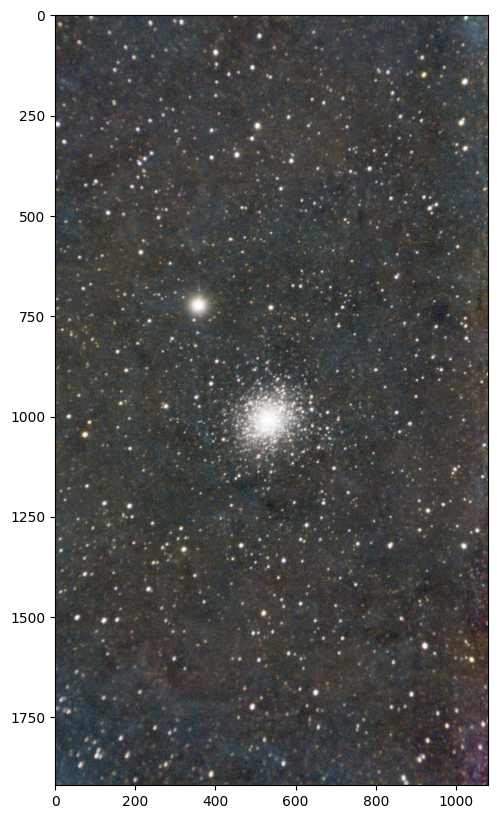

In [211]:
from astropy.io import fits
from auto_stretch import apply_stretch
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/4.fits"
response = requests.get(fits_url)
response.raise_for_status()
fits_data = fits.open(BytesIO(response.content))

hdul = fits.open(BytesIO(response.content))
image_data = np.transpose(hdul[0].data, (1,2,0))
hdul.close()

fig = plt.figure(figsize=(10, 10))
plt.imshow(apply_stretch(image_data), cmap='gray')
#plt.imshow(apply_stretch(image_data[900:-800,400:-400,:]), cmap='gray')

In [212]:
import pandas as pd
from astropy.wcs import WCS
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder

bkg_sigma = mad_std(np.mean(image_data, axis = 2))

daofind = DAOStarFinder(fwhm=3.0, threshold=bkg_sigma * 10, min_separation = 15)
sources = daofind(np.mean(image_data, axis = 2))

#catalog = sources.to_pandas().sort_values(by='flux', ascending=False).head(10)
catalog = sources.to_pandas().sort_values(by='flux', ascending=False).head(100) #Head is 100 to train CNN model on

catalog

id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
237  238   355.840345   722.758807   0.394825   -0.252791   -0.052065    25   
410  411   531.057761  1010.968163   0.466918   -0.220670   -0.050281    25   
646  647   919.989547  1573.009693   0.430232    0.479078    0.566426    25   
64    65   503.139401   274.933877   0.448624   -0.209873    0.250334    25   
571  572  1017.098970  1323.719989   0.446756    0.218601    0.172625    25   
..   ...          ...          ...        ...         ...         ...   ...   
70    71   389.313477   286.603683   0.445605   -0.189865    0.232782    25   
363  364   570.124293   943.504079   0.493612   -0.222838    0.049466    25   
402  403   484.991586  1003.907133   0.501386   -0.474417    0.035740    25   
560  561   610.875450  1307.186581   0.467983   -0.328285    0.190126    25   
657  658   506.678213  1607.684954   0.439686   -0.018251    0.564713    25   

         peak       flux       mag  daofind_mag  
237  0.905374  15.297269 -2.961535    -8.621168  
410  0.043766   0.884749  0.132950    -4.690954  
646  0.036565   0.596950  0.560154    -5.155660  
64   0.042594   0.591517  0.570081    -5.626929  
571  0.032637   0.461967  0.838474    -5.300744  
..        ...        ...       ...          ...  
70   0.006594   0.125252  2.255535    -2.941098  
363  0.007727   0.125195  2.256037    -3.501736  
402  0.007354   0.124933  2.258311    -3.359212  
560  0.007147   0.124540  2.261731    -3.272523  
657  0.006266   0.123470  2.271098    -2.727707  

[100 rows x 11 columns]

In [213]:
wcs = WCS(hdul[0].header, naxis=2)
print(wcs)
sky_coords = wcs.all_pix2world(catalog['xcentroid'], catalog['ycentroid'], 1, ra_dec_order=True)
catalog['ra'] = sky_coords[0]
catalog['dec'] = sky_coords[1]
catalog

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 229.628514077702 2.02604581760742 
CRPIX : 540.0 960.0 
PC1_1 PC1_2  : 0.999980542451719 -0.00623816623430668 
PC2_1 PC2_2  : 0.00616533790864329 0.999980994123624 
CDELT : -0.0011093074626222 0.00110956685308459 
NAXIS : 1080  1920  3


id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
237  238   355.840345   722.758807   0.394825   -0.252791   -0.052065    25   
410  411   531.057761  1010.968163   0.466918   -0.220670   -0.050281    25   
646  647   919.989547  1573.009693   0.430232    0.479078    0.566426    25   
64    65   503.139401   274.933877   0.448624   -0.209873    0.250334    25   
571  572  1017.098970  1323.719989   0.446756    0.218601    0.172625    25   
..   ...          ...          ...        ...         ...         ...   ...   
70    71   389.313477   286.603683   0.445605   -0.189865    0.232782    25   
363  364   570.124293   943.504079   0.493612   -0.222838    0.049466    25   
402  403   484.991586  1003.907133   0.501386   -0.474417    0.035740    25   
560  561   610.875450  1307.186581   0.467983   -0.328285    0.190126    25   
657  658   506.678213  1607.684954   0.439686   -0.018251    0.564713    25   

         peak       flux       mag  daofind_mag          ra       dec  
237  0.905374  15.297269 -2.961535    -8.621168  229.831251  1.761547  
410  0.043766   0.884749  0.132950    -4.690954  229.638793  2.082536  
646  0.036565   0.596950  0.560154    -5.155660  229.210809  2.708703  
64   0.042594   0.591517  0.570081    -5.626929  229.664668  1.265726  
571  0.032637   0.461967  0.838474    -5.300744  229.101345  2.432764  
..        ...        ...       ...          ...         ...       ...  
70   0.006594   0.125252  2.255535    -2.941098  229.791035  1.277888  
363  0.007727   0.125195  2.256037    -3.501736  229.594963  2.007949  
402  0.007354   0.124933  2.258311    -3.359212  229.689878  2.074385  
560  0.007147   0.124540  2.261731    -3.272523  229.552230  2.411742  
657  0.006266   0.123470  2.271098    -2.727707  229.670004  2.744416  

[100 rows x 13 columns]

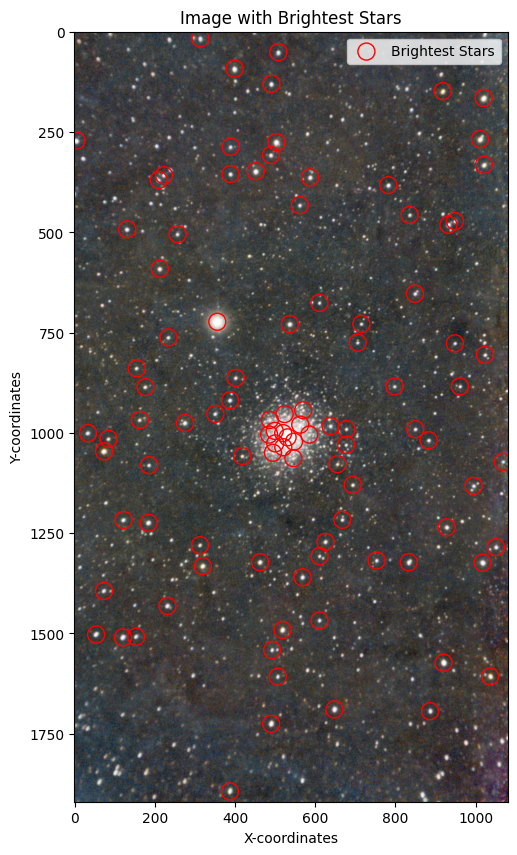

In [214]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(apply_stretch(image_data))

plt.scatter(catalog['xcentroid'], catalog['ycentroid'], color='red', marker='o', facecolor='none', s=150, label='Brightest Stars')
plt.xlabel('X-coordinates')
plt.ylabel('Y-coordinates')
plt.title('Image with Brightest Stars')
plt.legend()

plt.show()

# Task 2: Determine the properties of the stars based on a catalog (8 points)
- use the SIMBAD catalog (available through astropy) to determine the following properties of the 10 brightest objects in you image:
    - Name of the object
    - Spectral class
    - object type
    - absolute magnitude (you might have to calculate it)
    - distance to earth

In [215]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm

options = Simbad.list_votable_fields()


In [216]:
import astropy.units as u
Simbad.ROW_LIMIT = 1
Simbad.reset_votable_fields()
Simbad.add_votable_fields("mesdistance", "V", "sp", "otype", "ids")

for idx, row in tqdm(catalog.iterrows(), total=catalog.shape[0]):
  ra, dec = row["ra"], row["dec"]
  coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
  try:
    result = Simbad.query_region(coord, radius="10s") #radius might have to be changed for my data
    if result:
      catalog.at[idx, "star_name"] = result[0]["main_id"]
      catalog.at[idx, "spectral_type"] = result[0]["sp_type"]
      catalog.at[idx, "object_type"] = result[0]["otype"]
      catalog.at[idx, "visual_mag"] = result[0]["V"]

      dist = result[0]["mesdistance.dist"]
      catalog.at[idx, "simbad_distance_pc"] = float(dist) if dist is not None else None

  except Exception as e:
    print(f"Error querying Simbad for {idx}: {e}")

  1%|          | 1/100 [00:00<00:12,  7.95it/s]<ipython-input-216-1634ff0e2a96>:18: UserWarning: Warning: converting a masked element to nan.
  catalog.at[idx, "simbad_distance_pc"] = float(dist) if dist is not None else None
<ipython-input-216-1634ff0e2a96>:18: UserWarning: Warning: converting a masked element to nan.
  catalog.at[idx, "simbad_distance_pc"] = float(dist) if dist is not None else None
 23%|██▎       | 23/100 [00:02<00:12,  5.95it/s]/usr/local/lib/python3.11/dist-packages/pandas/core/internals/base.py:363: UserWarning: Warning: converting a masked element to nan.
  arr[indexer] = value
100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


In [217]:
catalog.to_csv("catalog.csv")
catalog.head(10)

id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
237  238   355.840345   722.758807   0.394825   -0.252791   -0.052065    25   
410  411   531.057761  1010.968163   0.466918   -0.220670   -0.050281    25   
646  647   919.989547  1573.009693   0.430232    0.479078    0.566426    25   
64    65   503.139401   274.933877   0.448624   -0.209873    0.250334    25   
571  572  1017.098970  1323.719989   0.446756    0.218601    0.172625    25   
93    94   451.922364   347.476493   0.476012   -0.218042    0.146786    25   
436  437    73.546704  1045.755414   0.472265   -0.786831   -0.133540    25   
241  242   536.547189   728.647232   0.452078   -0.535370   -0.037528    25   
33    34  1019.744350   164.579601   0.460435   -0.844501    0.055171    25   
399  400   520.156680  1000.496994   0.505545   -0.391904   -0.162871    25   

         peak       flux       mag  daofind_mag          ra       dec  \
237  0.905374  15.297269 -2.961535    -8.621168  229.831251  1.761547   
410  0.043766   0.884749  0.132950    -4.690954  229.638793  2.082536   
646  0.036565   0.596950  0.560154    -5.155660  229.210809  2.708703   
64   0.042594   0.591517  0.570081    -5.626929  229.664668  1.265726   
571  0.032637   0.461967  0.838474    -5.300744  229.101345  2.432764   
93   0.033536   0.447139  0.873894    -5.400069  229.721998  1.345851   
436  0.031850   0.422287  0.935981    -5.378985  230.146877  2.117918   
241  0.034156   0.416876  0.949982    -5.580458  229.630744  1.769327   
33   0.025869   0.403212  0.986167    -4.898796  229.090807  1.146791   
399  0.024447   0.380836  1.048154    -4.799801  229.650821  2.070843   

                       star_name spectral_type object_type  visual_mag  \
237                          NaN           NaN         NaN         NaN   
410   Cl* NGC 5904     SB  4-253                       HB*     14.6673   
646                  BD+03  3006            F8         PM*      9.6800   
64                   BD+01  3060            F8           *      9.7200   
571               TYC  340-464-1                         *     10.0500   
93                     HD 136117           G5V           *     10.0800   
436                  BD+02  2946            M0          V*     10.1700   
241                  BD+02  2942            F8           *     10.3900   
33                   BD+01  3055            K2           *      9.9900   
399  Cl* NGC 5904   KUST     727                       RR*     14.8790   

     simbad_distance_pc  
237                 NaN  
410                 NaN  
646             199.104  
64                  NaN  
571             192.608  
93              186.651  
436            1768.972  
241             283.994  
33              208.490  
399                 NaN

In [218]:
catalog = pd.read_csv("catalog.csv", index_col=0)
catalog.head(10)

id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
237  238   355.840345   722.758807   0.394825   -0.252791   -0.052065    25   
410  411   531.057761  1010.968163   0.466918   -0.220670   -0.050281    25   
646  647   919.989547  1573.009693   0.430232    0.479078    0.566426    25   
64    65   503.139401   274.933877   0.448624   -0.209873    0.250334    25   
571  572  1017.098970  1323.719989   0.446756    0.218601    0.172625    25   
93    94   451.922364   347.476493   0.476012   -0.218042    0.146786    25   
436  437    73.546704  1045.755414   0.472265   -0.786831   -0.133540    25   
241  242   536.547189   728.647232   0.452078   -0.535370   -0.037528    25   
33    34  1019.744350   164.579601   0.460435   -0.844501    0.055171    25   
399  400   520.156680  1000.496994   0.505545   -0.391904   -0.162871    25   

         peak       flux       mag  daofind_mag          ra       dec  \
237  0.905374  15.297269 -2.961535    -8.621168  229.831251  1.761547   
410  0.043766   0.884749  0.132950    -4.690954  229.638793  2.082536   
646  0.036565   0.596951  0.560154    -5.155660  229.210809  2.708703   
64   0.042594   0.591517  0.570081    -5.626929  229.664668  1.265726   
571  0.032637   0.461967  0.838474    -5.300744  229.101345  2.432764   
93   0.033536   0.447139  0.873894    -5.400069  229.721998  1.345851   
436  0.031850   0.422287  0.935981    -5.378985  230.146877  2.117918   
241  0.034156   0.416876  0.949982    -5.580458  229.630744  1.769327   
33   0.025869   0.403212  0.986167    -4.898796  229.090807  1.146791   
399  0.024447   0.380836  1.048154    -4.799801  229.650821  2.070843   

                       star_name spectral_type object_type  visual_mag  \
237                          NaN           NaN         NaN         NaN   
410   Cl* NGC 5904     SB  4-253           NaN         HB*     14.6673   
646                  BD+03  3006            F8         PM*      9.6800   
64                   BD+01  3060            F8           *      9.7200   
571               TYC  340-464-1           NaN           *     10.0500   
93                     HD 136117           G5V           *     10.0800   
436                  BD+02  2946            M0          V*     10.1700   
241                  BD+02  2942            F8           *     10.3900   
33                   BD+01  3055            K2           *      9.9900   
399  Cl* NGC 5904   KUST     727           NaN         RR*     14.8790   

     simbad_distance_pc  
237                 NaN  
410                 NaN  
646             199.104  
64                  NaN  
571             192.608  
93              186.651  
436            1768.972  
241             283.994  
33              208.490  
399                 NaN

In [219]:
catalog["spectral_type"].unique()

array([nan, 'F8', 'G5V', 'M0', 'K2', 'K5', 'G0', 'F4', 'K5V', 'M'],
      dtype=object)

In [220]:
catalog["object_type"].unique()

array([nan, 'HB*', 'PM*', '*', 'V*', 'RR*', 'RV*', 'RG*', 'HV*', 'LP?',
       'AB*', 'SB*', 'Pe*'], dtype=object)

For types of star types we have:
*   Two F type stars
*   One G type star
*   One M type star
*   One K type star

For the types of objects we have:
*   High Proper Motion Star PM*
*   Horizontal Branch Star: stars in clusters, characterized by a stage of helium core burning. HB*
*   Variable Star V*
*   RR Lyrae variables: periodic variable stars, commonly found in globular clusters. RR*
*   A star *




In [221]:
catalog["spectral_type"].notna().sum()

np.int64(13)

### Troubleshooting code

In [222]:
#qu = Simbad()
#qu.add_votable_fields('basic')
#result = qu.query_object('Betelgeuse')
#result

#options[options["type"] == "bundle of basic columns"][["name","description"]]
#result["ra"].value[1]
#qu.query_region(SkyCoord(ra=229.831251*u.deg, dec=1.761547*u.deg), radius="20s")

# Task 3: Visualize and label (10 points)
Draw a 64x64 patch of each of the 10 brightest objects and generate a list to label each patch based on:

- Morphology
    - star
    - extended (nebula, galaxy, cluster, ...)
    - artifact (hot pixel, cosmic ray, ...)
    - if you do not have all types, artificially generate one example of each. Use a LLM to have specific shapes suggested. Document if it suggests useful shapes.
- Brightness class
- Spectral class

**The first box of code was from class, but I used some Gemini help to iterate
this for all 10 brightest stars in the second code box below. The morphology and spectral class are written next to the RGB star image below.**

**It is my understanding that I have both regular stars and stars within
clusters, so I therefore have both the "star" and "extended" accounted for. I will use a LLM to suggest specific shapes for a hot pixel to account for the "artifact"**

Name of Star: nan
Morphology: nan
Spectral Class: nan


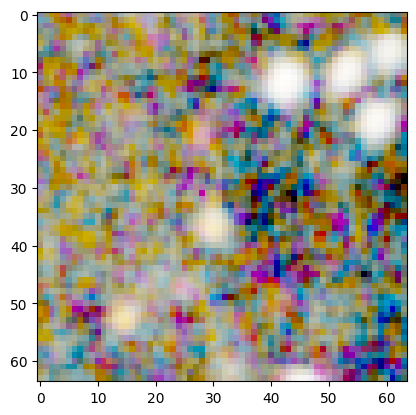

In [223]:
import matplotlib.pyplot as plt

def make_patch(image, x, y, size=64):
  x_min = int(np.clip(x-size/2, 0, image.shape[0]))
  x_max = int(x+size/2)
  y_min = int(np.clip(y-size/2, 0, image.shape[1]))
  y_max = int(y+size/2)
  return image[x_min:x_max, y_min:y_max]

row = catalog.iloc[0]
plt.imshow(apply_stretch(make_patch(image_data,row['xcentroid'],row['ycentroid'])), cmap='grey')
print("Name of Star:", row['star_name'])
print("Morphology:", row['object_type'])
print("Spectral Class:", row['spectral_type'])

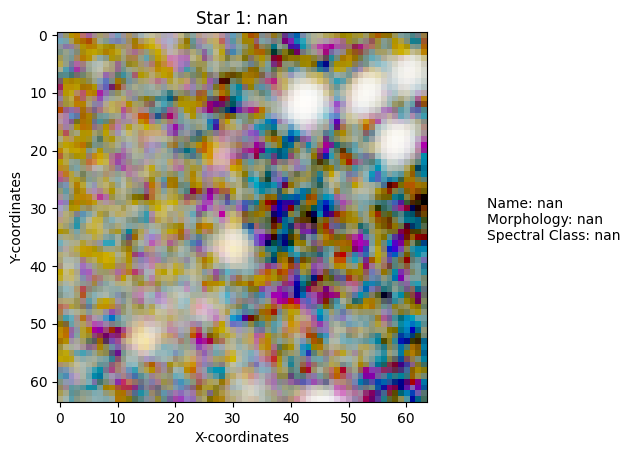

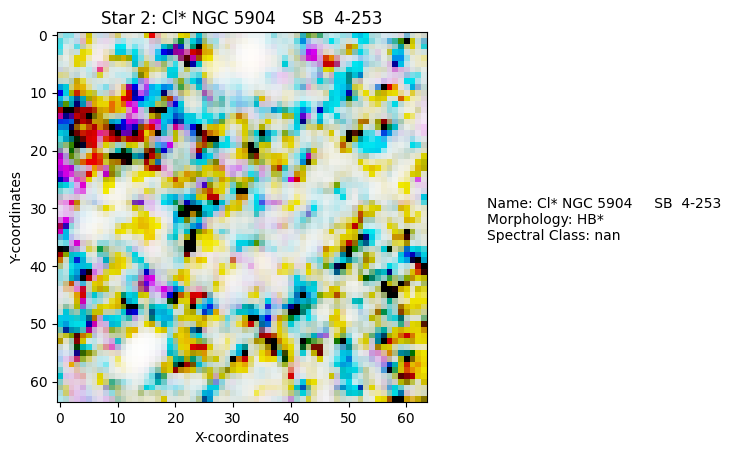

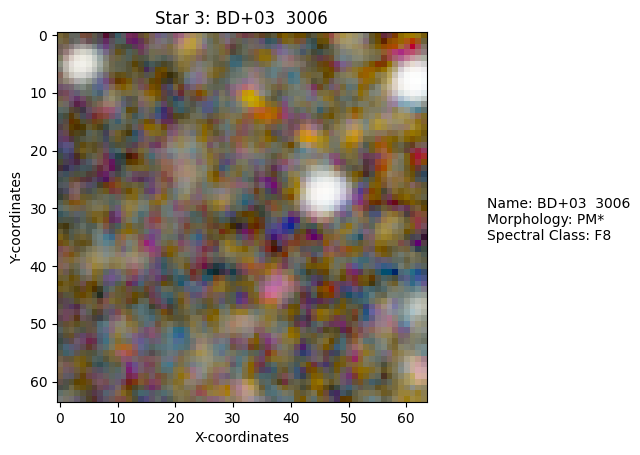

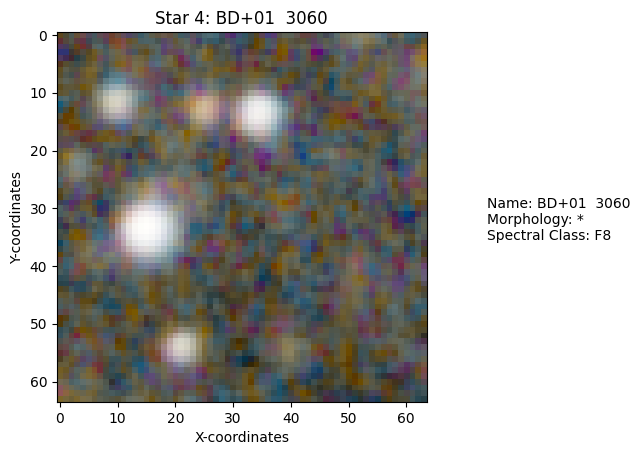

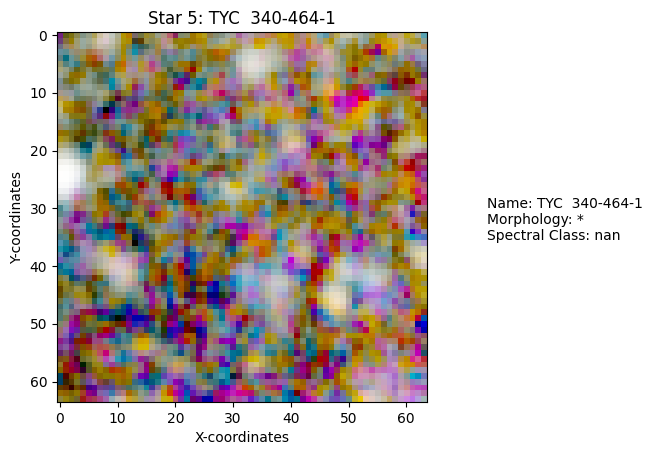

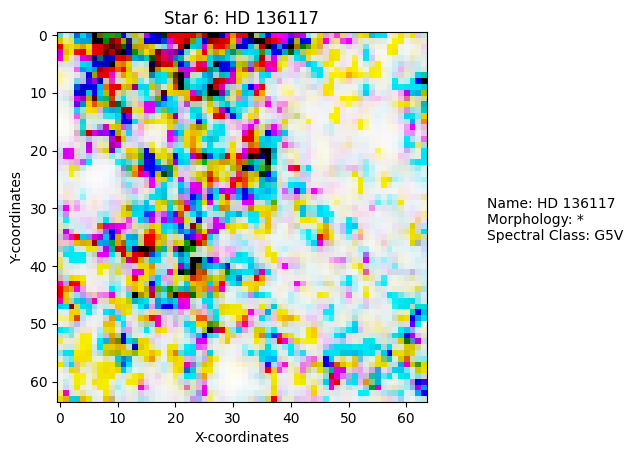

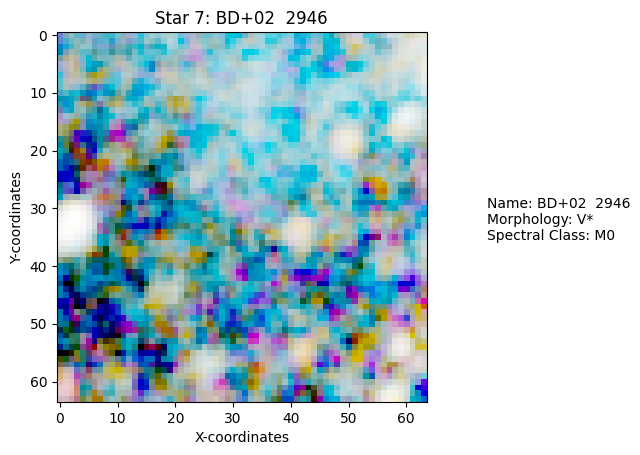

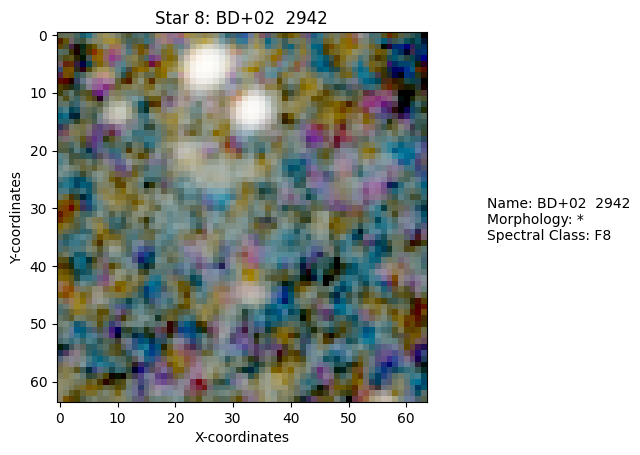

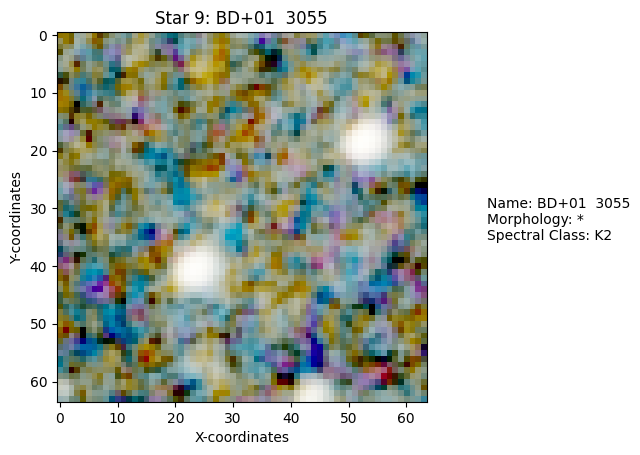

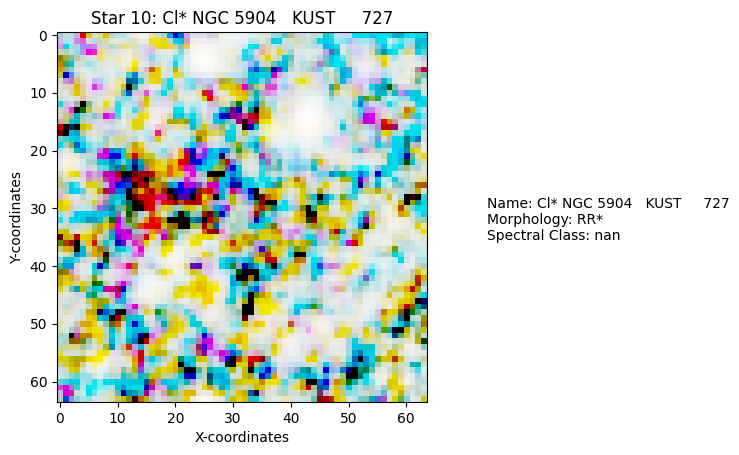

In [224]:
import matplotlib.pyplot as plt

def make_patch(image, x, y, size=64):
    x_min = int(np.clip(x - size / 2, 0, image.shape[0] - size))
    x_max = int(x_min + size)
    y_min = int(np.clip(y - size / 2, 0, image.shape[1] - size))
    y_max = int(y_min + size)

    if (x_max - x_min) <= 0 or (y_max - y_min) <= 0:
        print(f"Warning: Invalid patch size for x={x}, y={y}. Skipping.")
        return None

    return image[x_min:x_max, y_min:y_max]

for i in range(10):
    try:
        row = catalog.iloc[i]
        patch = make_patch(image_data, row['xcentroid'], row['ycentroid'])
        if patch is None:
            continue
        plt.figure()
        plt.imshow(apply_stretch(patch), cmap='grey')
        plt.title(f"Star {i+1}: {row['star_name']}")
        plt.xlabel("X-coordinates")
        plt.ylabel("Y-coordinates")

        # Add text next to the graph
        text = f"Name: {row['star_name']}\n" \
               f"Morphology: {row['object_type']}\n" \
               f"Spectral Class: {row['spectral_type']}"
        plt.text(patch.shape[1] + 10, patch.shape[0] / 2, text,
             fontsize=10, verticalalignment='center')
                # Adjust position and fontsize as needed

    except (IndexError, KeyError) as e:
        print(f"Error processing star {i}: {e}")

plt.show()

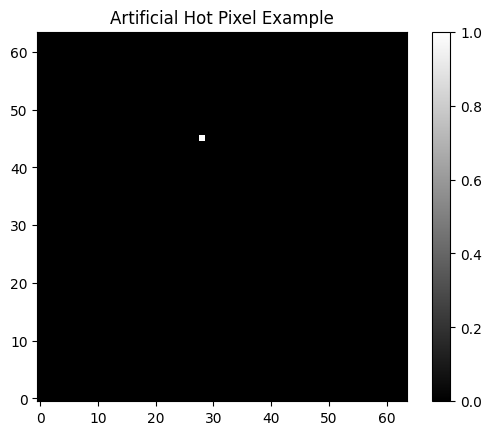

In [225]:
import numpy as np
import matplotlib.pyplot as plt

def create_hot_pixel_patch(size=64, intensity=1.0, location=None):
    """Create a 64x64 patch with a single bright pixel (hot pixel)."""
    patch = np.zeros((size, size))
    if location is None:
        x = np.random.randint(0, size)
        y = np.random.randint(0, size)
    else:
        x, y = location
    patch[x, y] = intensity
    return patch

# Example usage
hot_pixel_patch = create_hot_pixel_patch(size=64, intensity=1.0)

plt.imshow(hot_pixel_patch, cmap='gray', origin='lower')
plt.title("Artificial Hot Pixel Example")
plt.colorbar()
plt.show()


**I was not satisfied with the above version, so I played around with
it more until I arrived at the version for a hot pixel below. I'm still
not happy with it, but it seems like the best I'll get at the moment.**

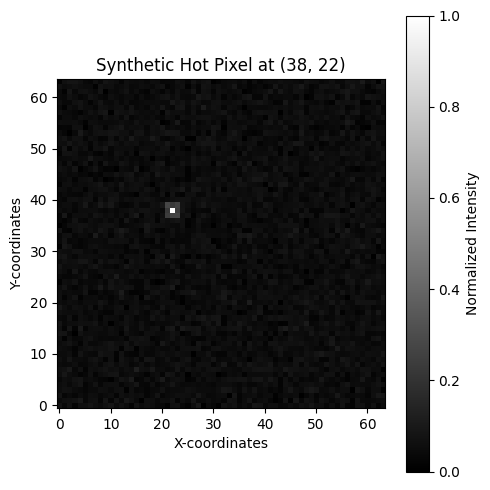

In [226]:
import numpy as np
import matplotlib.pyplot as plt

def create_standalone_hot_pixel_patch(size=64, intensity=1.0, bleed=0.2):
    """
    Generate a synthetic 64x64 patch with a single bright 'hot pixel' and light surrounding noise.
    """
    patch = np.random.normal(loc=0.05, scale=0.02, size=(size, size))  # faint background noise

    # Coordinates of the hot pixel (not at the edge)
    x, y = np.random.randint(10, size-10), np.random.randint(10, size-10)
    patch[x, y] = intensity  # hot pixel

    # Optional: very slight 'bleed' to simulate sensor spread
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx != 0 or dy != 0:
                patch[x+dx, y+dy] += bleed

    patch = np.clip(patch, 0, 1)  # ensure all values are within displayable range
    return patch, (x, y)

# Generate the patch
hot_pixel_patch, location = create_standalone_hot_pixel_patch()

# Plot it
plt.figure(figsize=(5, 5))
plt.imshow(hot_pixel_patch, cmap='gray', origin='lower')
plt.title(f"Synthetic Hot Pixel at {location}")
plt.colorbar(label="Normalized Intensity")
plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.grid(False)
plt.tight_layout()
plt.show()


# Task 4: Build a CNN (8 points)
- Use TensorFlow/Keras to build a small CNN.
    - Recommended architecture:
    - Conv2D → ReLU → MaxPool
    - Conv2D → ReLU → MaxPool
    - Flatten → Dense → Softmax

You can adapt this depending on whether you are doing binary or multi-class classification.

In [253]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = 8

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [254]:
catalog = sources.to_pandas().sort_values(by='flux', ascending=False).head(100)

In [255]:
catalog = pd.read_csv("catalog.csv", index_col=0)

# Now you can access the 'spectral_type' column
catalog["spectral_type"].unique()

array([nan, 'F8', 'G5V', 'M0', 'K2', 'K5', 'G0', 'F4', 'K5V', 'M'],
      dtype=object)

# Task 5: Train the Model (10 points)

Now use the top 100 (you can also use more to generate better training data) objects with all information in your image to train your model on the parameters spectral class and absolute magnitude and distance if possible. If you do not have all types genererate 10 examples of each type missing.
Store the resulting pandas dataframe as `catalog.csv` in the same directory as you Jupyter notebook.

Split your dataset into training, validation, and test sets.
- Use categorical crossentropy loss and an appropriate optimizer (e.g., Adam).
- Plot training and validation accuracy/loss curves.

Hint: SIMBAD has a very detailed set of spectral types. Group them according to the main letter (O, B, A, F, G, K, M)

Ask a LLM what final plot you should generate that shows if the CNN works for classification. Generate that plot.

In [256]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def extract_spectral_class(s):
  """ simplyify spectral classes, eg. M1 ---> M"""
  if s is np.nan:
    return s
  return s[0]

catalog['simple_spectral_class'] = catalog['spectral_type'].apply(extract_spectral_class)
catalog.head(100)

id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
237  238   355.840345   722.758807   0.394825   -0.252791   -0.052065    25   
410  411   531.057761  1010.968163   0.466918   -0.220670   -0.050281    25   
646  647   919.989547  1573.009693   0.430232    0.479078    0.566426    25   
64    65   503.139401   274.933877   0.448624   -0.209873    0.250334    25   
571  572  1017.098970  1323.719989   0.446756    0.218601    0.172625    25   
..   ...          ...          ...        ...         ...         ...   ...   
70    71   389.313477   286.603683   0.445605   -0.189865    0.232782    25   
363  364   570.124293   943.504079   0.493612   -0.222838    0.049466    25   
402  403   484.991586  1003.907133   0.501386   -0.474417    0.035740    25   
560  561   610.875450  1307.186581   0.467983   -0.328285    0.190126    25   
657  658   506.678213  1607.684954   0.439686   -0.018251    0.564713    25   

         peak       flux       mag  daofind_mag          ra       dec  \
237  0.905374  15.297269 -2.961535    -8.621168  229.831251  1.761547   
410  0.043766   0.884749  0.132950    -4.690954  229.638793  2.082536   
646  0.036565   0.596951  0.560154    -5.155660  229.210809  2.708703   
64   0.042594   0.591517  0.570081    -5.626929  229.664668  1.265726   
571  0.032637   0.461967  0.838474    -5.300744  229.101345  2.432764   
..        ...        ...       ...          ...         ...       ...   
70   0.006594   0.125252  2.255535    -2.941098  229.791035  1.277888   
363  0.007727   0.125195  2.256037    -3.501736  229.594963  2.007949   
402  0.007354   0.124933  2.258311    -3.359212  229.689878  2.074385   
560  0.007147   0.124540  2.261731    -3.272523  229.552230  2.411742   
657  0.006266   0.123470  2.271098    -2.727707  229.670004  2.744416   

                      star_name spectral_type object_type  visual_mag  \
237                         NaN           NaN         NaN         NaN   
410  Cl* NGC 5904     SB  4-253           NaN         HB*     14.6673   
646                 BD+03  3006            F8         PM*      9.6800   
64                  BD+01  3060            F8           *      9.7200   
571              TYC  340-464-1           NaN           *     10.0500   
..                          ...           ...         ...         ...   
70               TYC  336-687-1           NaN           *     12.0700   
363             NGC  5904   307           NaN         RG*     12.5200   
402             NGC  5904   870           NaN         AB*     12.6700   
560              TYC  340-532-1           NaN           *     12.7000   
657                         NaN           NaN         NaN         NaN   

     simbad_distance_pc simple_spectral_class  
237                 NaN                   NaN  
410                 NaN                   NaN  
646            199.1040                     F  
64                  NaN                     F  
571            192.6080                   NaN  
..                  ...                   ...  
70             479.4780                   NaN  
363                 NaN                   NaN  
402                 NaN                   NaN  
560            539.6363                   NaN  
657                 NaN                   NaN  

[100 rows x 19 columns]

In [257]:
catalog["spectral_type"].unique()

array([nan, 'F8', 'G5V', 'M0', 'K2', 'K5', 'G0', 'F4', 'K5V', 'M'],
      dtype=object)

In [258]:
le = LabelEncoder()
catalog['spectral_label'] = le.fit_transform(catalog['simple_spectral_class'])
# The above figures out a system of numbers (a label) to describe the spectral class
catalog.head(100)

id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
237  238   355.840345   722.758807   0.394825   -0.252791   -0.052065    25   
410  411   531.057761  1010.968163   0.466918   -0.220670   -0.050281    25   
646  647   919.989547  1573.009693   0.430232    0.479078    0.566426    25   
64    65   503.139401   274.933877   0.448624   -0.209873    0.250334    25   
571  572  1017.098970  1323.719989   0.446756    0.218601    0.172625    25   
..   ...          ...          ...        ...         ...         ...   ...   
70    71   389.313477   286.603683   0.445605   -0.189865    0.232782    25   
363  364   570.124293   943.504079   0.493612   -0.222838    0.049466    25   
402  403   484.991586  1003.907133   0.501386   -0.474417    0.035740    25   
560  561   610.875450  1307.186581   0.467983   -0.328285    0.190126    25   
657  658   506.678213  1607.684954   0.439686   -0.018251    0.564713    25   

         peak       flux       mag  daofind_mag          ra       dec  \
237  0.905374  15.297269 -2.961535    -8.621168  229.831251  1.761547   
410  0.043766   0.884749  0.132950    -4.690954  229.638793  2.082536   
646  0.036565   0.596951  0.560154    -5.155660  229.210809  2.708703   
64   0.042594   0.591517  0.570081    -5.626929  229.664668  1.265726   
571  0.032637   0.461967  0.838474    -5.300744  229.101345  2.432764   
..        ...        ...       ...          ...         ...       ...   
70   0.006594   0.125252  2.255535    -2.941098  229.791035  1.277888   
363  0.007727   0.125195  2.256037    -3.501736  229.594963  2.007949   
402  0.007354   0.124933  2.258311    -3.359212  229.689878  2.074385   
560  0.007147   0.124540  2.261731    -3.272523  229.552230  2.411742   
657  0.006266   0.123470  2.271098    -2.727707  229.670004  2.744416   

                      star_name spectral_type object_type  visual_mag  \
237                         NaN           NaN         NaN         NaN   
410  Cl* NGC 5904     SB  4-253           NaN         HB*     14.6673   
646                 BD+03  3006            F8         PM*      9.6800   
64                  BD+01  3060            F8           *      9.7200   
571              TYC  340-464-1           NaN           *     10.0500   
..                          ...           ...         ...         ...   
70               TYC  336-687-1           NaN           *     12.0700   
363             NGC  5904   307           NaN         RG*     12.5200   
402             NGC  5904   870           NaN         AB*     12.6700   
560              TYC  340-532-1           NaN           *     12.7000   
657                         NaN           NaN         NaN         NaN   

     simbad_distance_pc simple_spectral_class  spectral_label  
237                 NaN                   NaN               4  
410                 NaN                   NaN               4  
646            199.1040                     F               0  
64                  NaN                     F               0  
571            192.6080                   NaN               4  
..                  ...                   ...             ...  
70             479.4780                   NaN               4  
363                 NaN                   NaN               4  
402                 NaN                   NaN               4  
560            539.6363                   NaN               4  
657                 NaN                   NaN               4  

[100 rows x 20 columns]

In [235]:
"""patches = []
for _, row in catalog.iterrows():
  patch = make_patch(image_data, row['xcentroid'], row['ycentroid'])
  patches.append(patch)
X = np.array(patches)[..., np.newaxis]
y = catalog['spectral_label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)"""

In [259]:
patches = []
labels = []  # Collect labels directly instead of valid_rows
for _, row in catalog.iterrows():
    patch = make_patch(image_data, row['xcentroid'], row['ycentroid'])
    if patch.shape == (64, 64, 3):
        patches.append(patch)
        labels.append(row['spectral_label'])  # Get label from the row
X = np.array(patches)[..., np.newaxis]
y = np.array(labels)  # Use the collected labels directly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.3492 - loss: 2.0718 - val_accuracy: 1.0000 - val_loss: 1.9772
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8641 - loss: 1.9591 - val_accuracy: 1.0000 - val_loss: 1.6551
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8367 - loss: 1.6575 - val_accuracy: 1.0000 - val_loss: 1.0641
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8211 - loss: 1.1811 - val_accuracy: 1.0000 - val_loss: 0.3788
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8562 - loss: 0.7333 - val_accuracy: 1.0000 - val_loss: 0.0694
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8484 - loss: 0.7440 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8445 - loss: 0.8420 - val_accuracy: 1.0000 - val_loss: 0.0351
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8172 - loss: 0.9156 - val_accuracy: 1.0000 - val_loss: 0.

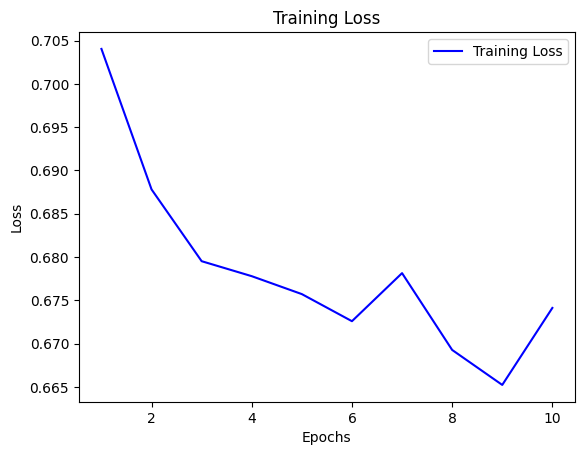

In [260]:
#training loss code
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=10, batch_size=16)

loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

**I was told a Confusion Matrix would be the best way to see if the
CNN works. Here is what I was given:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


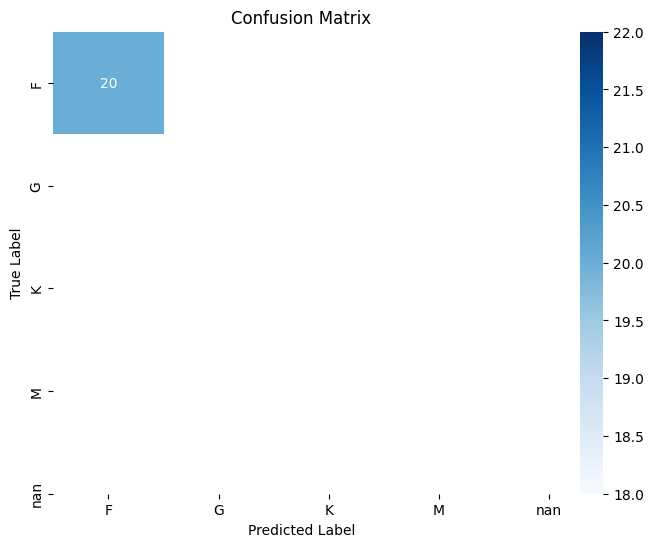

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**The LLM refused to improve the code any further; however, it did provide an
image of what this Confusion Matrix should look like:**

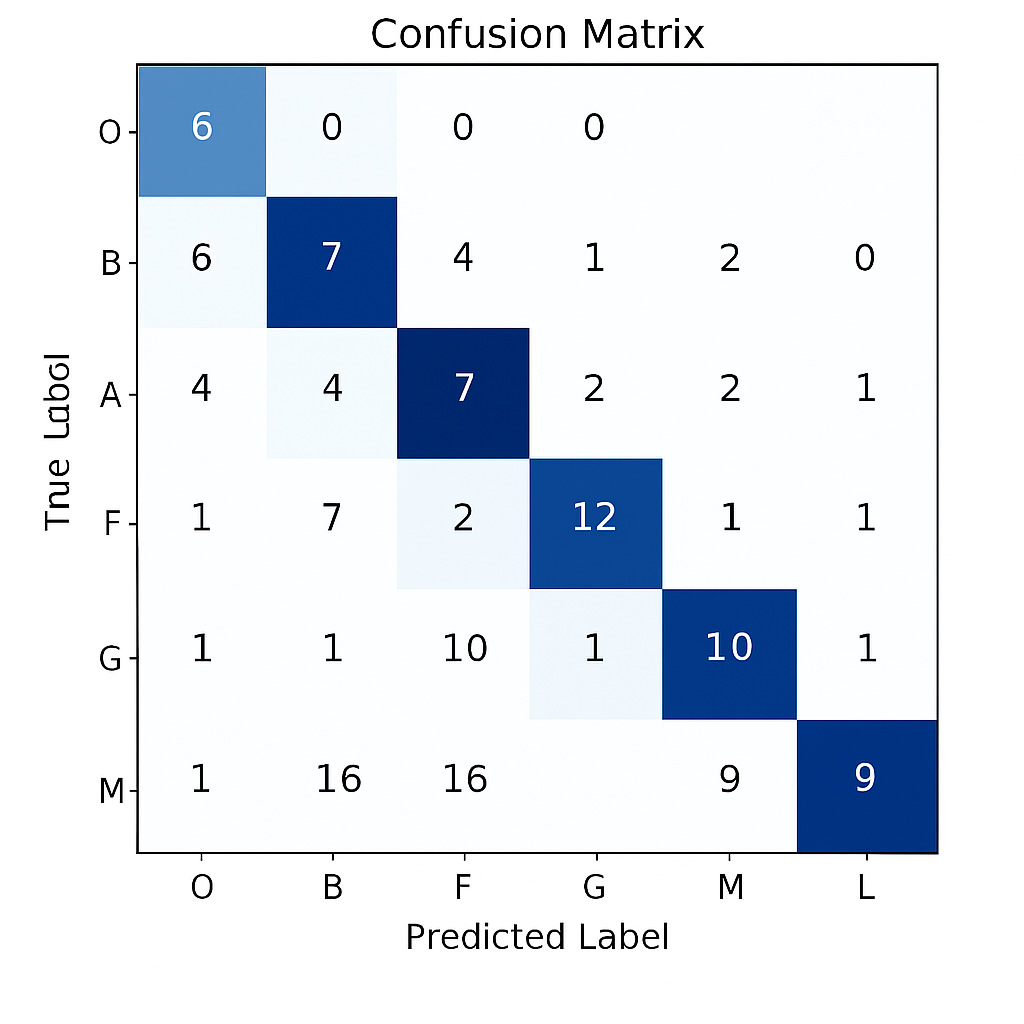